In [4]:
import pysm3
import pysm3.units as u
import astropy.io.fits as fits

import healpy as hp
from fgbuster import (CMB, Dust, Synchrotron,
                      basic_comp_sep,
                      get_observation, get_noise_realization, get_instrument, get_sky)
from fgbuster.visualization import corner_norm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

### Variables from "Patch_create" 

In [5]:
nside    = 4096
pix_size = 0.8588716029543515 #arcmin

Nx = 800
Ny = 600


X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10      


print(f"Patch con {Nx} x {Ny} pixels, ognuno di {pix_size} arcmin, per una dimensione totale di {X_width:.2f} x {Y_width:.2f} gradi")

Patch con 800 x 600 pixels, ognuno di 0.8588716029543515 arcmin, per una dimensione totale di 11.45 x 8.59 gradi


### Leggo i dati

In [6]:
patch2d_I40 = fits.getdata("patch2d/patch2d_I40")
patch2d_Q40 = fits.getdata("patch2d/patch2d_Q40")
patch2d_U40 = fits.getdata("patch2d/patch2d_U40")

patch2d_I60 = fits.getdata("patch2d/patch2d_I60")
patch2d_Q60 = fits.getdata("patch2d/patch2d_Q60")
patch2d_U60 = fits.getdata("patch2d/patch2d_U60")


patch2d_I68 = fits.getdata("patch2d/patch2d_I68")
patch2d_Q68 = fits.getdata("patch2d/patch2d_Q68")
patch2d_U68 = fits.getdata("patch2d/patch2d_U68")


patch2d_I78 = fits.getdata("patch2d/patch2d_I78")
patch2d_Q78 = fits.getdata("patch2d/patch2d_Q78")
patch2d_U78 = fits.getdata("patch2d/patch2d_U78")


patch2d_I89 = fits.getdata("patch2d/patch2d_I89")
patch2d_Q89 = fits.getdata("patch2d/patch2d_Q89")
patch2d_U89 = fits.getdata("patch2d/patch2d_U89")


patch2d_I100 = fits.getdata("patch2d/patch2d_I100")
patch2d_Q100 = fits.getdata("patch2d/patch2d_Q100")
patch2d_U100 = fits.getdata("patch2d/patch2d_U100")

patch2d_I119 = fits.getdata("patch2d/patch2d_I119")
patch2d_Q119 = fits.getdata("patch2d/patch2d_I119")
patch2d_U119 = fits.getdata("patch2d/patch2d_I119")

patch2d_I140 = fits.getdata("patch2d/patch2d_I140")
patch2d_Q140 = fits.getdata("patch2d/patch2d_I140")
patch2d_U140 = fits.getdata("patch2d/patch2d_I140")

In [7]:
np.shape(patch2d_I40)

(600, 800)

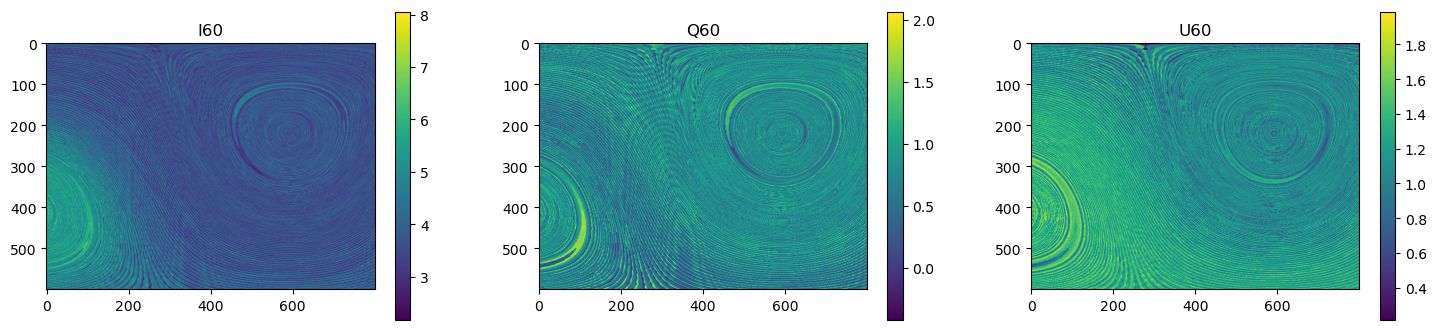

In [8]:
maps = [patch2d_I60, patch2d_Q60, patch2d_U60]
title = ['I60', 'Q60', 'U60']

fig, axs = plt.subplots(1, 3, figsize=(18,4))

for i in range(len(maps)):
    im = axs[i].imshow(maps[i], cmap='viridis')  
    axs[i].set_title(title[i])  
    cbar = fig.colorbar(im, ax=axs[i]) 

plt.show()

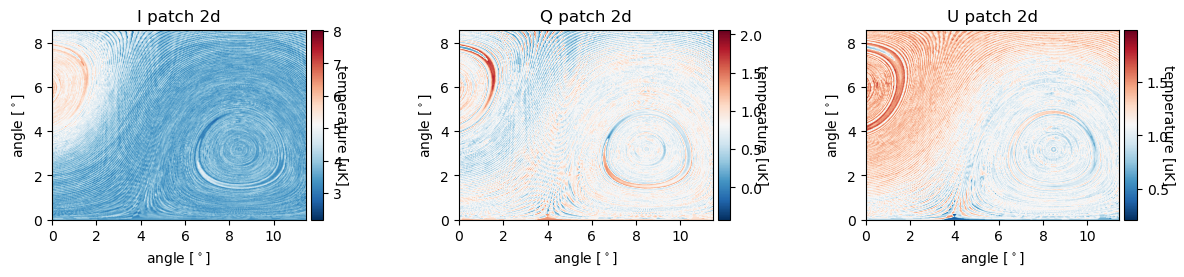

In [9]:
# PLOT

Map_to_Plot = [patch2d_I60, patch2d_Q60, patch2d_U60]
title = ["I patch 2d","Q patch 2d","U patch 2d"]
c_factor_max = [np.max(patch2d_I60), np.max(patch2d_Q60), np.max(patch2d_U60)]
c_factor_min = [np.min(patch2d_I60), np.min(patch2d_Q60), np.min(patch2d_U60)]

fig, axs = plt.subplots(1, 3, figsize=(14, 8))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_max, c_factor_iter_min) in enumerate(zip(Map_to_Plot, c_factor_max, c_factor_min)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

#plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.2, top=0.90)
#plt.suptitle('Maps convolution with beam', fontsize=20)
plt.show()

# Analisi

### BEAM

ellipticity =  -0.3333333333333333


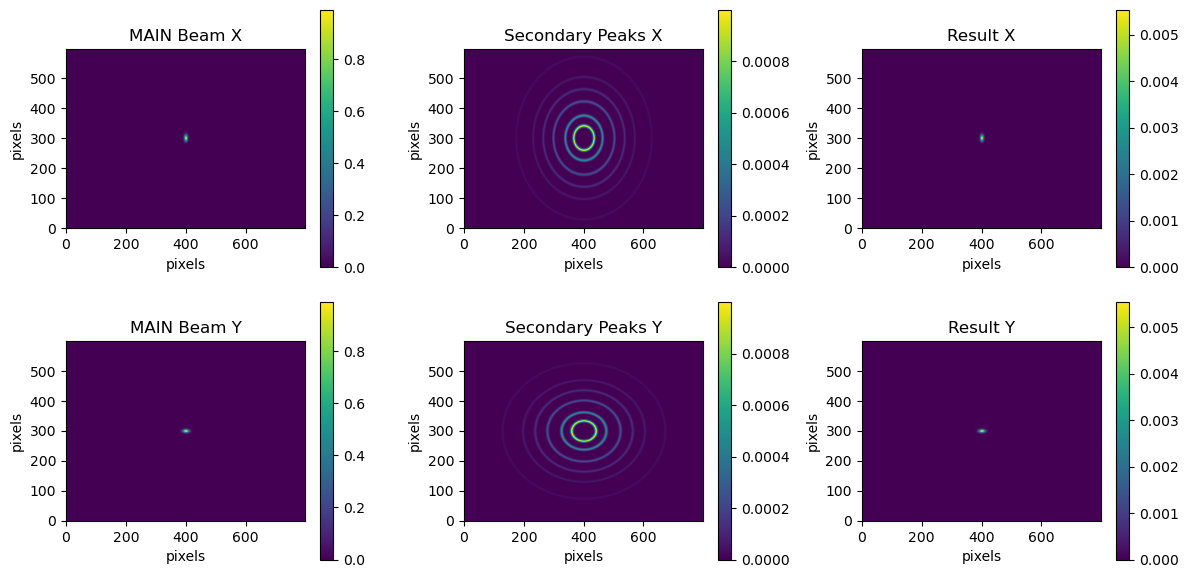

In [10]:
# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(Nx)
Ny = int(Ny)

onesx = np.ones(Nx)
onesy = np.ones(Ny)

indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

#X = np.outer(onesy, indsx)
#Y = np.outer(indsy, onesx)
X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)


#####################################################################################

# VARIABLES

FWHM_x = 15  #degrees
FWHM_y = 30  #degrees
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)

array_dB = np.array([-20, -22,  -24, -26, -28, -30])  #max values of the secondary peaks
array_dB = array_dB * 1.5
r1 = np.array([30, 55, 90, 120, 150, 200]) #angular distance of the peaks
r = 4 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 


#########################################################################################

# BEAM

beam_gauss_x, beam_gauss_y, sec_rings_x,sec_rings_y, beam_x, beam_y = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, theta, array_dB, r, r1, X, Y, a, ellipticity)

########################################################################################

# PLOT

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
titles = ['MAIN Beam X', 'Secondary Peaks X', 'Result X', 'MAIN Beam Y', 'Secondary Peaks Y', 'Result Y']
data_list = [beam_gauss_x, sec_rings_x, beam_x, beam_gauss_y, sec_rings_y, beam_y]

for i, ax in enumerate(axes.flat):
    im = ax.imshow(data_list[i], cmap='viridis', origin='lower')
    ax.set_title(titles[i])
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    cbar = plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

beam max: 4.342923104481638e-05 beam min: 3.4852325694415835
beam max: 4.342923104481638e-05 beam min: 3.4852325694415835


0

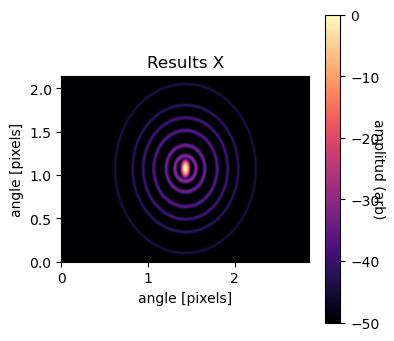

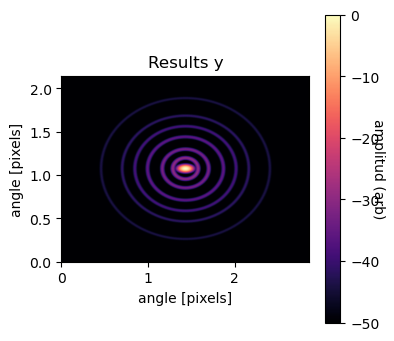

In [11]:
beam_to_plot = beam_x
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/4, Y_width/4, "Results X", "angle [pixels]")

beam_to_plot = beam_y
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/4, Y_width/4, "Results y", "angle [pixels]")

In [12]:
### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":1.5,"R":70.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-4,"Diam":20.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 2.5,"N":5,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

beam max: 4.342923104481638e-05 beam min: 3.5103783280794802
beam max: 4.342923104481638e-05 beam min: 3.5079342618543095
beam max: 4.342923104481638e-05 beam min: 3.5079342618543095
beam max: 4.342923104481638e-05 beam min: 3.550410655560319
beam max: 4.342923104481638e-05 beam min: 3.545489134051711


0

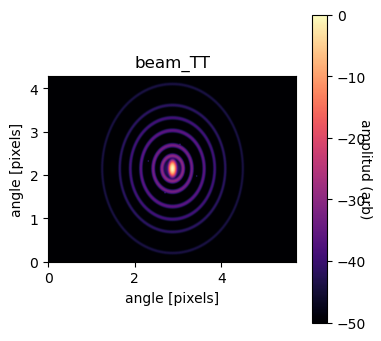

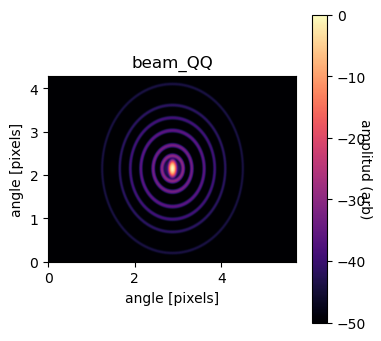

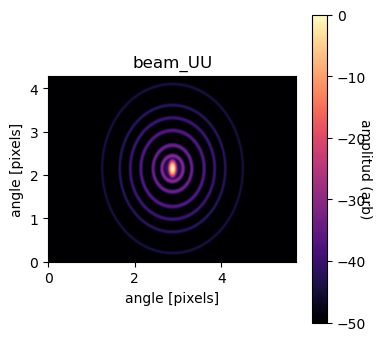

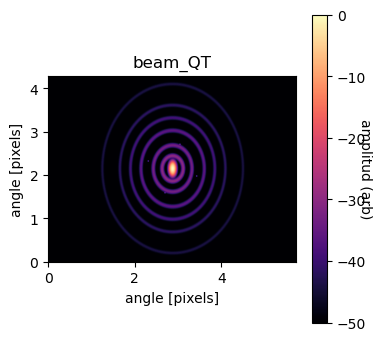

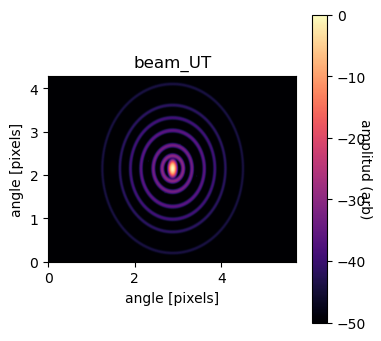

In [13]:
beam_sys = BeamSystematics()
beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT, beam_QU, beam_UQ = make_systematics_beams_r(Nx, Ny, pix_size, FWHM_x, beam_x, bs)


######################################################################################################################################
beam_to_plot = beam_TT
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2,  "beam_TT", 'angle [pixels]')

beam_to_plot = beam_QQ
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2, "beam_QQ", 'angle [pixels]')
                                                            
beam_to_plot = beam_UU
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2,"beam_UU", 'angle [pixels]')


beam_to_plot = beam_QT
if np.any(beam_to_plot <= 0):
    beam_to_plot[beam_to_plot <= 0] = 1e-21
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2, "beam_QT", 'angle [pixels]')

beam_to_plot = beam_UT
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
if np.any(beam_to_plot <= 0):
    beam_to_plot[beam_to_plot <= 0] = 1e-21
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2, "beam_UT", 'angle [pixels]')

In [14]:
# convolution with perfect beam
perf_beam, no1, no2, no3, no4, no5 = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, 0, array_dB, r, r1, X, Y, a, ellipticity)
perf_beam = perf_beam / np.sum(perf_beam)

Q_conv_perf_40 = convolve_map_with_beam(patch2d_Q40, perf_beam)
U_conv_perf_40 = convolve_map_with_beam(patch2d_U40, perf_beam)

Q_conv_perf_60 = convolve_map_with_beam(patch2d_Q60, perf_beam)
U_conv_perf_60 = convolve_map_with_beam(patch2d_U60, perf_beam)

Q_conv_perf_68 = convolve_map_with_beam(patch2d_Q68, perf_beam)
U_conv_perf_68 = convolve_map_with_beam(patch2d_U68, perf_beam)

Q_conv_perf_78 = convolve_map_with_beam(patch2d_Q78, perf_beam)
U_conv_perf_78 = convolve_map_with_beam(patch2d_U78, perf_beam)

Q_conv_perf_89 = convolve_map_with_beam(patch2d_Q89, perf_beam)
U_conv_perf_89 = convolve_map_with_beam(patch2d_U89, perf_beam)

Q_conv_perf_100 = convolve_map_with_beam(patch2d_Q100, perf_beam)
U_conv_perf_100 = convolve_map_with_beam(patch2d_U100, perf_beam)

Q_conv_perf_119 = convolve_map_with_beam(patch2d_Q119, perf_beam)
U_conv_perf_119 = convolve_map_with_beam(patch2d_U119, perf_beam)

Q_conv_perf_140 = convolve_map_with_beam(patch2d_Q140, perf_beam)
U_conv_perf_140 = convolve_map_with_beam(patch2d_U140, perf_beam)

# convolution with real beam
I_conv_real_40 = convolve_map_with_beam(patch2d_I40, beam_TT)
Q_conv_real_40 = convolve_map_with_beam(patch2d_Q40, beam_QQ)
U_conv_real_40 = convolve_map_with_beam(patch2d_U40, beam_UU)

I_conv_real_60 = convolve_map_with_beam(patch2d_I60, beam_TT)
Q_conv_real_60 = convolve_map_with_beam(patch2d_Q60, beam_QQ)
U_conv_real_60 = convolve_map_with_beam(patch2d_U60, beam_UU)

I_conv_real_68 = convolve_map_with_beam(patch2d_I68, beam_TT)
Q_conv_real_68 = convolve_map_with_beam(patch2d_Q68, beam_QQ)
U_conv_real_68 = convolve_map_with_beam(patch2d_U68, beam_UU)

I_conv_real_78 = convolve_map_with_beam(patch2d_I78, beam_TT)
Q_conv_real_78 = convolve_map_with_beam(patch2d_Q78, beam_QQ)
U_conv_real_78 = convolve_map_with_beam(patch2d_U78, beam_UU)

I_conv_real_89 = convolve_map_with_beam(patch2d_I89, beam_TT)
Q_conv_real_89 = convolve_map_with_beam(patch2d_Q89, beam_QQ)
U_conv_real_89 = convolve_map_with_beam(patch2d_U89, beam_UU)

I_conv_real_100 = convolve_map_with_beam(patch2d_I100, beam_TT)
Q_conv_real_100 = convolve_map_with_beam(patch2d_Q100, beam_QQ)
U_conv_real_100 = convolve_map_with_beam(patch2d_U100, beam_UU)

I_conv_real_119 = convolve_map_with_beam(patch2d_I119, beam_TT)
Q_conv_real_119 = convolve_map_with_beam(patch2d_Q119, beam_QQ)
U_conv_real_119 = convolve_map_with_beam(patch2d_U119, beam_UU)

I_conv_real_140 = convolve_map_with_beam(patch2d_I140, beam_TT)
Q_conv_real_140 = convolve_map_with_beam(patch2d_Q140, beam_QQ)
U_conv_real_140 = convolve_map_with_beam(patch2d_U140, beam_UU)

## Polarization angle

In [15]:
std_deviation_degree = 1
std_deviation_rad    = std_deviation_degree * np.pi / 180
gauss_center  = 0

print(std_deviation_rad)

0.017453292519943295


In [16]:

def cosine_window_r(Nx, Ny, pix_size):
    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system

    Nx = int(Nx)
    Ny = int(Ny)

    onesx = np.ones(Nx)
    onesy = np.ones(Ny)

    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

    X = np.outer(onesy, indsx)
    Y = np.outer(indsy, onesx)

    # make a window map
    window_map = np.cos(X) * np.cos(Y)
   
    # return the window map
    return(window_map)

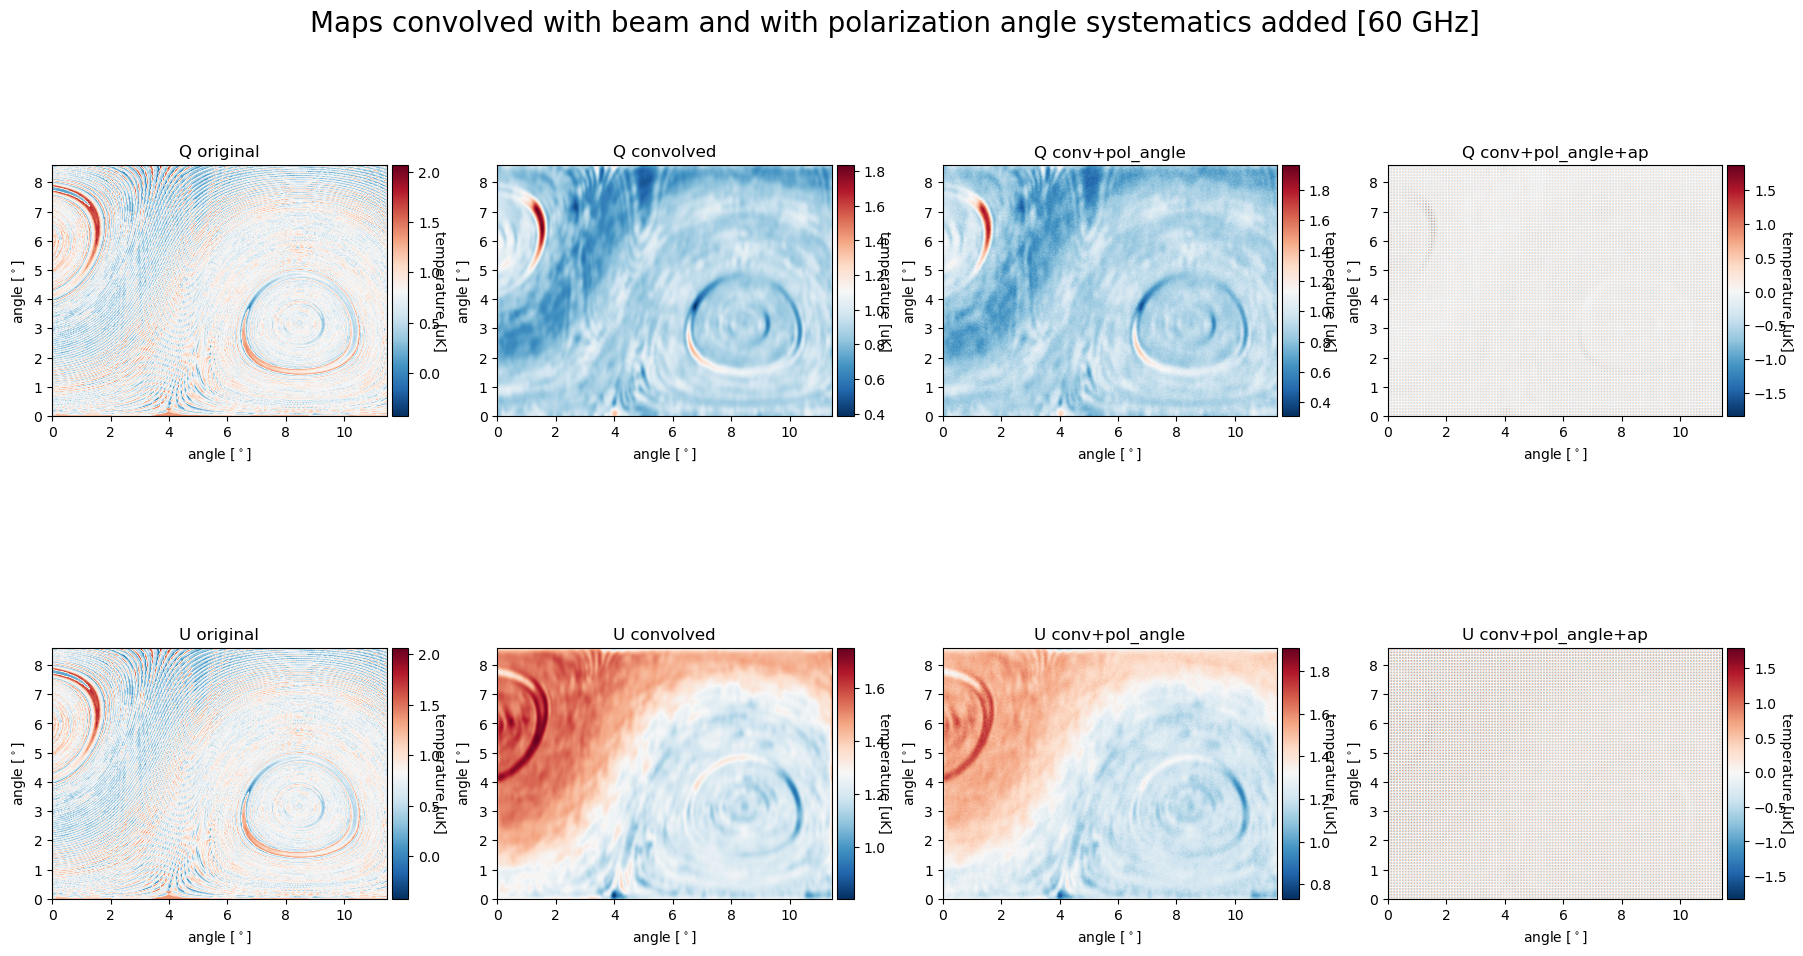

In [17]:
# POLARIZATION ANGLE
Q_pert40, U_pert40   = polangle_map(Q_conv_real_40, U_conv_real_40, gauss_center, std_deviation_rad)
Q_pert60, U_pert60   = polangle_map(Q_conv_real_60, U_conv_real_60, gauss_center, std_deviation_rad)
Q_pert68, U_pert68   = polangle_map(Q_conv_real_68, U_conv_real_68, gauss_center, std_deviation_rad)
Q_pert78, U_pert78   = polangle_map(Q_conv_real_78, U_conv_real_78, gauss_center, std_deviation_rad)
Q_pert89, U_pert89   = polangle_map(Q_conv_real_89, U_conv_real_89, gauss_center, std_deviation_rad)
Q_pert100, U_pert100 = polangle_map(Q_conv_real_100, U_conv_real_100, gauss_center, std_deviation_rad)
Q_pert119, U_pert119 = polangle_map(Q_conv_real_119, U_conv_real_119, gauss_center, std_deviation_rad)
Q_pert140, U_pert140 = polangle_map(Q_conv_real_140, U_conv_real_140, gauss_center, std_deviation_rad)

########################################################################################################

# APODIZATION
window = (cosine_window_r(Nx, Ny, pix_size))

Q_ap40 = window * Q_pert40
U_ap40 = window * U_pert40
I_ap40 = window * I_conv_real_40


Q_ap60 = window * Q_pert60
U_ap60 = window * U_pert60
I_ap60 = window * I_conv_real_60

Q_ap68 = window * Q_pert68
U_ap68 = window * U_pert68
I_ap68 = window * I_conv_real_68

Q_ap78 = window * Q_pert78
U_ap78 = window * U_pert78
I_ap78 = window * I_conv_real_78

Q_ap89 = window * Q_pert89
U_ap89 = window * U_pert89
I_ap89 = window * I_conv_real_89

Q_ap100 = window * Q_pert100
U_ap100 = window * U_pert100
I_ap100 = window * I_conv_real_100

Q_ap119 = window * Q_pert119
U_ap119 = window * U_pert119
I_ap119 = window * I_conv_real_119

Q_ap140 = window * Q_pert140
U_ap140 = window * U_pert140
I_ap140 = window * I_conv_real_140

########################################################################################################

# plot
Map_to_Plot = [patch2d_Q60, Q_conv_real_60,Q_pert60,Q_ap60, patch2d_Q60, U_conv_real_60 ,U_pert60, U_ap60]
title = ["Q original","Q convolved","Q conv+pol_angle", "Q conv+pol_angle+ap", "U original","U convolved", "U conv+pol_angle", "U conv+pol_angle+ap"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5]), np.max(Map_to_Plot[6]), np.max(Map_to_Plot[7])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5]), np.min(Map_to_Plot[6]), np.min(Map_to_Plot[7])]

fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Maps convolved with beam and with polarization angle systematics added [60 GHz]', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelPerturbation.png')
plt.show()


# Component separation

### Conversione in 1d
I è stata convoluta e deconvoluta con il beam (no angolo di polarizzazione). Non so se è giusto ma serve anche I per ricreare un array fgbuster del tipo (3, n_pix) e fare la component separation. 

In [18]:
I_deconv_flat40 = I_ap40.flatten()
Q_deconv_flat40 = Q_ap40.flatten()
U_deconv_flat40 = U_ap40.flatten()

I_deconv_flat60 = I_ap60.flatten()
Q_deconv_flat60 = Q_ap60.flatten()
U_deconv_flat60 = U_ap60.flatten()

I_deconv_flat68 = I_ap68.flatten()
Q_deconv_flat68 = Q_ap68.flatten()
U_deconv_flat68 = U_ap68.flatten()

I_deconv_flat78 = I_ap78.flatten()
Q_deconv_flat78 = Q_ap78.flatten()
U_deconv_flat78 = U_ap78.flatten()

I_deconv_flat89 = I_ap89.flatten()
Q_deconv_flat89 = Q_ap89.flatten()
U_deconv_flat89 = U_ap89.flatten()

I_deconv_flat100 = I_ap100.flatten()
Q_deconv_flat100 = Q_ap100.flatten()
U_deconv_flat100 = U_ap100.flatten()

I_deconv_flat119 = I_ap119.flatten()
Q_deconv_flat119 = Q_ap119.flatten()
U_deconv_flat119 = U_ap119.flatten()

I_deconv_flat140 = I_ap140.flatten()
Q_deconv_flat140 = Q_ap140.flatten()
U_deconv_flat140 = U_ap140.flatten()

In [19]:
# devo ritornare ad avere elementi del tipo (6, 3, n_pix)
freq40 = np.stack([I_deconv_flat40, Q_deconv_flat40, U_deconv_flat40])
freq60 = np.stack([I_deconv_flat60, Q_deconv_flat60, U_deconv_flat60])
freq68 = np.stack([I_deconv_flat68, Q_deconv_flat68, U_deconv_flat68])
freq78 = np.stack([I_deconv_flat78, Q_deconv_flat78, U_deconv_flat78])
freq89 = np.stack([I_deconv_flat89, Q_deconv_flat89, U_deconv_flat89])
freq100 = np.stack([I_deconv_flat100, Q_deconv_flat100, U_deconv_flat100])
freq119 = np.stack([I_deconv_flat119, Q_deconv_flat119, U_deconv_flat119])
freq140 = np.stack([I_deconv_flat140, Q_deconv_flat140, U_deconv_flat140])

full_array = np.array([freq40, freq60, freq68, freq78, freq89, freq100, freq119, freq140])
np.shape(full_array)

(8, 3, 480000)

In [20]:
instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
freq = df.iloc[[0, 2, 3, 4, 5, 6, 7, 8], :]   #estraggo le frequenze che ho selezionato creando le patch

freq

frequency  depth_p  depth_i  fwhm  f_sky    status  \
0       40.0    37.42    26.46  70.5    1.0  forecast   
2       60.0    21.31    15.07  51.1    1.0  forecast   
3       68.0    16.87    11.93  47.1    1.0  forecast   
4       78.0    12.07     8.53  43.8    1.0  forecast   
5       89.0    11.30     7.99  41.5    1.0  forecast   
6      100.0     6.56     4.64  37.8    1.0  forecast   
7      119.0     4.58     3.24  33.6    1.0  forecast   
8      140.0     4.79     3.39  30.8    1.0  forecast   

                    reference       type  \
0  arXiv:2202.02773, Table 13  satellite   
2  arXiv:2202.02773, Table 13  satellite   
3  arXiv:2202.02773, Table 13  satellite   
4  arXiv:2202.02773, Table 13  satellite   
5  arXiv:2202.02773, Table 13  satellite   
6  arXiv:2202.02773, Table 13  satellite   
7  arXiv:2202.02773, Table 13  satellite   
8  arXiv:2202.02773, Table 13  satellite   

                                                note experiment  
0  Different instruments at the same freq were co...   LiteBIRD  
2  Different instruments at the same freq were co...   LiteBIRD  
3  Different instruments at the same freq were co...   LiteBIRD  
4  Different instruments at the same freq were co...   LiteBIRD  
5  Different instruments at the same freq were co...   LiteBIRD  
6  Different instruments at the same freq were co...   LiteBIRD  
7  Different instruments at the same freq were co...   LiteBIRD  
8  Different instruments at the same freq were co...   LiteBIRD

In [21]:
components = [CMB(), Dust(350.), Synchrotron(40.)]

# component separation
result = basic_comp_sep(components, freq, full_array)

print(result.params)
print(result.x)

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[47.56890134  0.13158373 -3.22391443]


In [22]:
np.shape(result.s)
# sono 3 mappe I, Q e U per cmb, dust e sync. ma non so quali
# credo siano nello stesso ordine dell'input, quindi I, Q, U ma in un esempio chiama result.s[0,0] come Q della cmb, ma dovrebbe essere la I...

(3, 3, 480000)

In [23]:
cmb_I  = result.s[0,0]
cmb_Q  = result.s[0,1]
cmb_U  = result.s[0,2]

In [24]:
np.shape(cmb_I)

(480000,)

In [25]:
fits.writeto("cmb_I", cmb_I, overwrite=True)
fits.writeto("cmb_Q", cmb_Q, overwrite=True)
fits.writeto("cmb_U", cmb_U, overwrite=True)

In [26]:
cmb_I = fits.getdata("cmb_I")
cmb_Q = fits.getdata("cmb_Q")
cmb_U = fits.getdata("cmb_U")

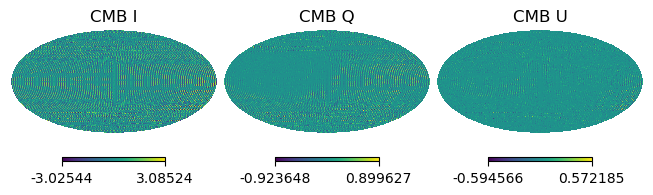

In [27]:
hp.mollview(cmb_I, title='CMB I', sub=(1, 3, 1))
hp.mollview(cmb_Q, title='CMB Q', sub=(1, 3, 2))
hp.mollview(cmb_U, title='CMB U', sub=(1, 3, 3))

Le mappe sono tornate 1D, quindi devo di nuovo trasformale in 2D. A questo punto saranno con un numero di pizel un po' più piccolo e "sbagliato" ma non dovendo usare più healpy posso lasciarle così. Non saranno più 600 * 800

In [28]:
x = 1200
#np.sqrt(len(cmb_I)*2)
int(x)

1200

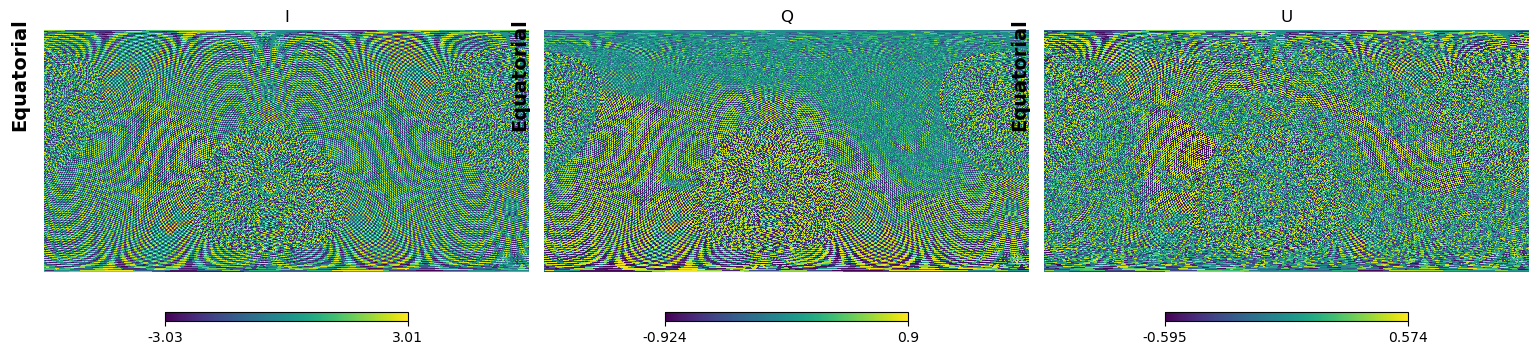

In [29]:
plt.figure(figsize=(15, 5))
cmb_I_2d = hp.cartview(cmb_I, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="I", sub=(1, 3, 1))
cmb_Q_2d = hp.cartview(cmb_Q, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="Q", sub=(1, 3, 2))
cmb_U_2d = hp.cartview(cmb_U, coord=['G','C'], return_projected_map=True, xsize=x,norm='hist', title="U", sub=(1, 3, 3))


In [30]:
cmb_I_2d = cmb_I_2d[:600, :800]
cmb_Q_2d = cmb_Q_2d[:600, :800]
cmb_U_2d = cmb_U_2d[:600, :800]

In [31]:
np.shape(cmb_I_2d)

(600, 800)

## Deconvolution

In [32]:
I_deconv = correct_lr_r(cmb_I_2d/window, perf_beam,Nx, Ny, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)
Q_deconv = correct_lr_r(cmb_Q_2d/window, perf_beam,Nx, Ny, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)
U_deconv = correct_lr_r(cmb_U_2d/window, perf_beam,Nx, Ny, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)

/home/rguidetti/.conda/envs/cmb/lib/python3.10/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [33]:
# convoluzione con beam perfetto
I_conv_perf = convolve_map_with_beam(cmb_I_2d, perf_beam)
Q_conv_perf = convolve_map_with_beam(cmb_Q_2d, perf_beam)
U_conv_perf = convolve_map_with_beam(cmb_U_2d, perf_beam)

# DIFFERENCE
Q_diff = (Q_conv_perf- Q_deconv)
U_diff = (U_conv_perf- U_deconv)

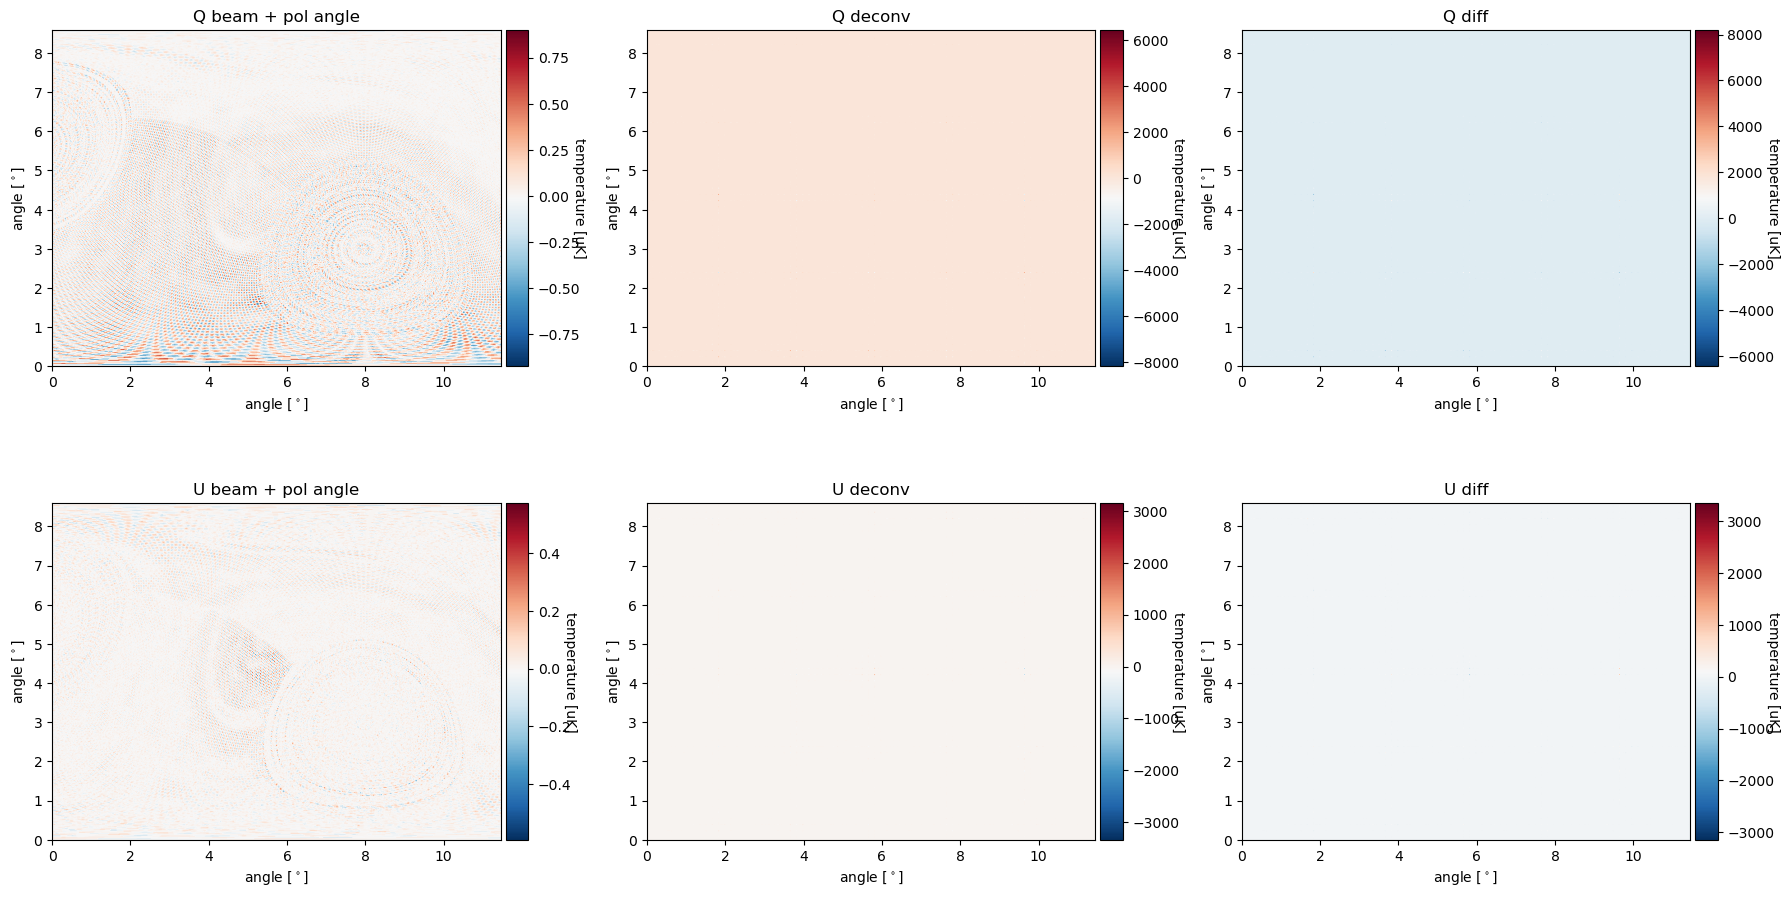

In [34]:
Map_to_Plot = [cmb_Q_2d ,Q_deconv, Q_diff, cmb_U_2d ,U_deconv, U_diff]
title = ["Q beam + pol angle", "Q deconv", "Q diff", "U beam + pol angle", "U deconv", "U diff"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4]), np.max(Map_to_Plot[5])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4]), np.min(Map_to_Plot[5])]



fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
#plt.suptitle('Maps convolved with beam and with polarization angle systematics added', fontsize=20)
plt.show()


In [35]:
# non serve più trasformare in EB con NaMaster
'''
def QU2EB_r(Nx, Ny,pix_size,Qmap,Umap,):
    

    # Create 2d Fourier coordinate system.
    onesx = np.ones(Nx)
    onesy = np.ones(Ny)
    indsx  = (np.arange(Nx) - Nx/2.) /(Nx-1.)
    indsy  = (np.arange(Ny) - Ny/2.) /(Ny-1.)

    
    kX = np.outer(onesy,indsx) / (pix_size/60. * np.pi/180.)
    kY = np.outer(indsy, onesx) / (pix_size/60. * np.pi/180.)
    
    ang = np.arctan2(kY,kX)
 
    # Convert to Fourier domain.
    fQ = np.fft.fftshift(np.fft.fft2(Qmap))
    fU = np.fft.fftshift(np.fft.fft2(Umap))
    
    # Convert Q, U to E, B in Fourier domain.
    fE = fQ * np.cos(2.*ang) + fU * np.sin(2. *ang)
    fB = - fQ * np.sin(2.*ang) + fU * np.cos(2. *ang)
    
    # Convert E, B from Fourier to real space.
    Emap = np.real(np.fft.ifft2(np.fft.fftshift(fE)))
    Bmap = np.real(np.fft.ifft2(np.fft.fftshift(fB)))

    return Emap, Bmap
    
    
    
# FROM QU TO EB 
E_deconv, B_deconv = QU2EB_r(nx, ny,pix_size,Q_deconv,U_deconv)
E_diff, B_diff     = QU2EB_r(nx, ny,pix_size,Q_diff,U_diff)
E_conv, B_conv     = QU2EB_r(nx, ny,pix_size,Q_conv_perf,U_conv_perf)

#E_conv = convolve_map_with_beam(E_map, perf_beam)
#B_conv = convolve_map_with_beam(B_map, perf_beam)



map_list      = [E_conv, E_deconv, E_diff, B_conv, B_deconv, B_diff] 
title_list    = ["E map original", "E after con-deconv", "E difference", "B map original", "B after conv-deconv", "B difference"]
c_factor_max = [np.max(E_conv), np.max(E_deconv), np.max(E_diff), np.max(B_conv), np.max(B_deconv), np.max(B_diff)]
c_factor_min = [np.min(E_conv), np.min(E_deconv), np.min(E_diff), np.min(B_conv), np.min(B_deconv), np.min(B_diff)]


fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs      = axs.flatten()

for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title_list[i])
        
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.90)
plt.suptitle('E and B maps- before and after conv-deconv', fontsize=16)
plt.show()


'''

'\ndef QU2EB_r(Nx, Ny,pix_size,Qmap,Umap,):\n    \n\n    # Create 2d Fourier coordinate system.\n    onesx = np.ones(Nx)\n    onesy = np.ones(Ny)\n    indsx  = (np.arange(Nx) - Nx/2.) /(Nx-1.)\n    indsy  = (np.arange(Ny) - Ny/2.) /(Ny-1.)\n\n    \n    kX = np.outer(onesy,indsx) / (pix_size/60. * np.pi/180.)\n    kY = np.outer(indsy, onesx) / (pix_size/60. * np.pi/180.)\n    \n    ang = np.arctan2(kY,kX)\n \n    # Convert to Fourier domain.\n    fQ = np.fft.fftshift(np.fft.fft2(Qmap))\n    fU = np.fft.fftshift(np.fft.fft2(Umap))\n    \n    # Convert Q, U to E, B in Fourier domain.\n    fE = fQ * np.cos(2.*ang) + fU * np.sin(2. *ang)\n    fB = - fQ * np.sin(2.*ang) + fU * np.cos(2. *ang)\n    \n    # Convert E, B from Fourier to real space.\n    Emap = np.real(np.fft.ifft2(np.fft.fftshift(fE)))\n    Bmap = np.real(np.fft.ifft2(np.fft.fftshift(fB)))\n\n    return Emap, Bmap\n    \n    \n    \n# FROM QU TO EB \nE_deconv, B_deconv = QU2EB_r(nx, ny,pix_size,Q_deconv,U_deconv)\nE_diff, B_dif

## Power spectra with NaMaster

In [36]:
import pymaster as nmt

In [37]:
# Masks:
# Let's now create a mask:
mask = np.ones_like(Q_deconv)

In [38]:
pix_size_rad = np.radians(pix_size /60)


X_width_rad = Nx * pix_size_rad
Y_width_rad = Ny * pix_size_rad

In [39]:
# Fields:
f0 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [I_deconv])
f2 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [Q_deconv, U_deconv], purify_b=True)

In [40]:
# Bins:
l0_bins = np.arange(Nx/8) * 8 * np.pi/X_width_rad
lf_bins = (np.arange(Nx/8)+1) * 8 * np.pi/X_width_rad
b = nmt.NmtBinFlat(l0_bins, lf_bins)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

In [41]:
# workspace
w00 = nmt.NmtWorkspaceFlat()
w02 = nmt.NmtWorkspaceFlat()
w22 = nmt.NmtWorkspaceFlat()

In [47]:
'''
w00.compute_coupling_matrix(f0, f0, b)
w02.compute_coupling_matrix(f0, f2, b)
w22.compute_coupling_matrix(f2, f2, b)

w00.write_to("w00_flat.fits")
w02.write_to("w02_flat.fits")
w22.write_to("w22_flat.fits")
'''

In [45]:
w00.read_from("w00_flat.fits")
w02.read_from("w02_flat.fits")
w22.read_from("w22_flat.fits")

In [48]:
# Computing power spectra:

cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
cl00_uncoupled = w00.decouple_cell(cl00_coupled)
cl02_coupled = nmt.compute_coupled_cell_flat(f0, f2, b)
cl02_uncoupled = w02.decouple_cell(cl02_coupled)
cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
cl22_uncoupled = w22.decouple_cell(cl22_coupled)

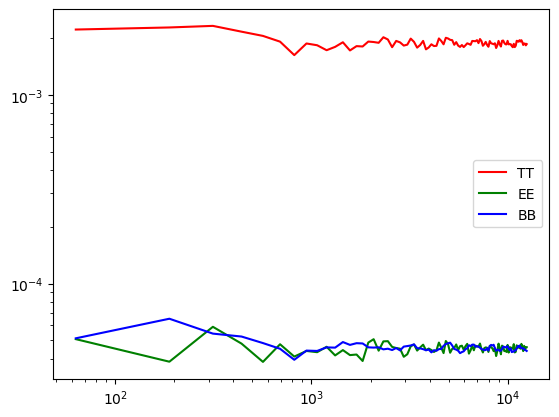

In [51]:
plt.figure()
#plt.plot(l, cl_tt, 'r-', label='Input TT')
#plt.plot(l, cl_ee, 'g-', label='Input EE')
#plt.plot(l, cl_bb, 'b-', label='Input BB')
plt.plot(ells_uncoupled, cl00_uncoupled[0], 'r', label='TT')
plt.plot(ells_uncoupled, cl22_uncoupled[0], 'g', label='EE')
plt.plot(ells_uncoupled, cl22_uncoupled[3], 'b', label='BB')
plt.loglog()
plt.legend()
plt.show()